## Introduction

### Definitions

##### Global Blocktree
A global tree maintained during the simulation used to determine certain statistics

##### Node Tree
A Node has a tree structure consisting of tree blocks just like in the Longest Chain Protocol.

##### Main Chain
On a tree structure, the main chain is defined in this protocol as the Longest Chain from the Genesis block to a leaf block.

##### Node Pool
A node also has a pool structure consisting of pool blocks. 

##### Tree Block
A block on the global blocktree or in a node's local tree.

##### Pool Block
A block in a node's local pool. The block may or may not be referenced by the next tree block proposed by the node.

##### Finalized
A block is considered finalized in two cases:

1) If in a tree block - if the block is `k` blocks deep on the main chain
2) If in a pool block - if the pool block is referenced by a tree block that is finalized

A transaction is considered finalized if it is in a finalized block

## Simulation Description

We measure multiple metrics to understand a transactions behavior during the simulation. 

#### Throughput
How many of the transactions generated actually get finalized in the simulation? 

#### Pool Block Arrival Latency
How long does it take for a transaction to make it into a pool block and get referenced?

#### Main Chain Arrival Latency
How long does it take for a transaction to make it onto the main chain?

#### Finalization Latency
How long does it take for a transaction to be finalized once it arrives on the main chain?


### Experimental Parameters

In [1]:
import numpy as np
%matplotlib inline

num_tests = 10

tree_proposal_rates = np.linspace(0.1, 0.1, num_tests)
pool_proposal_rates = np.linspace(0.1, 5, num_tests)
n_trials = 1
import json

# Create experimental parameters and write to JSON file

params = {'Block tree proposal rate parameter': 0,
 'Block pool proposal rate parameter': 0,
 'Transaction rate parameter': 0,
 'Block size (txs)': 50,
 'Duration (sec)': 0,
 'Fork choice rule': 'longest-chain-with-pool',
 'Network model': 'Decker-Wattenhorf',
 'Number of adversaries': 1,
 'Number of nodes': 100,
 'Probability of error in transaction confirmation': 0.1,
 'Transaction dataset': 'poisson',
 'Logging enabled': True}

### Run experiments

In [2]:
import os, shutil, pprint, glob, csv

pp = pprint.PrettyPrinter()
os.system('touch longest_chain_with_pool.json')
os.chdir('..')

import metrics

throughputs = {}
main_chain_arrival_latencies = {}
pool_block_latencies = {}
finalization_latencies = {}
hist_data = {}

for i in range(0, num_tests):
    tree_rate = tree_proposal_rates[i]
    pool_rate = pool_proposal_rates[i]
    params['Block tree proposal rate parameter'] = tree_rate
    params['Block pool proposal rate parameter'] = pool_rate
    params['Transaction rate parameter'] = pool_rate*int(params['Block size (txs)'])
    params['Duration (sec)'] = 300
    d = {}
    d['setting-name'] = f'longest-chain-with-pool'
    d[f'longest-chain-with-pool'] = params
    print('Parameters:')
    pp.pprint(d)
    with open('results/longest_chain_with_pool.json', 'w+') as outfile:
        json.dump(d, outfile)
    throughputs[(tree_rate, pool_rate)] = []
    main_chain_arrival_latencies[(tree_rate, pool_rate)] = []
    pool_block_latencies[(tree_rate, pool_rate)] = []
    finalization_latencies[(tree_rate, pool_rate)] = []
    for trial in range(0, n_trials):
        os.system('python3 main.py -f results/longest_chain_with_pool.json')
        throughput = metrics.compute_throughput()
        avg_main_chain_arrival_latency, avg_pool_block_latency, avg_finalization_latency = metrics.compute_latency()
        throughputs[(tree_rate, pool_rate)].append(throughput)
        main_chain_arrival_latencies[(tree_rate, pool_rate)].append(avg_main_chain_arrival_latency)
        pool_block_latencies[(tree_rate, pool_rate)].append(avg_pool_block_latency)
        finalization_latencies[(tree_rate, pool_rate)].append(avg_finalization_latency)
    
os.chdir('results/')
os.remove('longest_chain_with_pool.json')
print('Throughputs:\n', throughputs)
print('Main Chain Arrival Latencies:\n', main_chain_arrival_latencies)
print('Pool Block Latencies:\n', pool_block_latencies)
print('Finalization Latencies:\n', finalization_latencies)

Parameters:
{'longest-chain-with-pool': {'Block pool proposal rate parameter': 0.1,
                             'Block size (txs)': 50,
                             'Block tree proposal rate parameter': 0.1,
                             'Duration (sec)': 300,
                             'Fork choice rule': 'longest-chain-with-pool',
                             'Logging enabled': True,
                             'Network model': 'Decker-Wattenhorf',
                             'Number of adversaries': 1,
                             'Number of nodes': 100,
                             'Probability of error in transaction confirmation': 0.1,
                             'Transaction dataset': 'poisson',
                             'Transaction rate parameter': 5.0},
 'setting-name': 'longest-chain-with-pool'}
Parameters:
{'longest-chain-with-pool': {'Block pool proposal rate parameter': 0.6444444444444445,
                             'Block size (txs)': 50,
                      

Throughputs:
 {(0.1, 0.1): [3.484], (0.1, 0.6444444444444445): [11.576], (0.1, 1.188888888888889): [8.884], (0.1, 1.7333333333333336): [13.484], (0.1, 2.277777777777778): [16.356], (0.1, 2.8222222222222224): [20.068], (0.1, 3.366666666666667): [17.868], (0.1, 3.911111111111112): [18.252], (0.1, 4.455555555555556): [22.34], (0.1, 5.0): [25.776]}
Main Chain Arrival Latencies:
 {(0.1, 0.1): [46.64769575592758], (0.1, 0.6444444444444445): [128.7153329394039], (0.1, 1.188888888888889): [125.31488228592593], (0.1, 1.7333333333333336): [138.03993023386568], (0.1, 2.277777777777778): [159.47913126815098], (0.1, 2.8222222222222224): [165.49754532363085], (0.1, 3.366666666666667): [153.3741283630506], (0.1, 3.911111111111112): [154.46141360478632], (0.1, 4.455555555555556): [181.3427034481943], (0.1, 5.0): [158.62612142836915]}
Pool Block Latencies:
 {(0.1, 0.1): [115.18164581252046], (0.1, 0.6444444444444445): [231.7208762938317], (0.1, 1.188888888888889): [213.38849869313094], (0.1, 1.73333333

### Compute Averages

Average throughput is the number of finalized transactions divided by the duration of the experiment.

Average main chain latency is the time for a transaction to be added to the global blocktree - the timestamp the transaction was generated.

Average pool block latency is the time for a transaction to be added to a pool block AND referenced by a tree block.

Average finalization latency is the time for a transaction to be k blocks deep - to be added to the global blocktree.

In [3]:
avg_throughputs = {}
for rate in throughputs:
    avg_throughputs[rate] = sum(throughputs[rate])/len(throughputs[rate])

print("Average Throughputs:", avg_throughputs)
    
avg_main_chain_latencies = {}
for rate in main_chain_arrival_latencies:
    avg_main_chain_latencies[rate] = sum(main_chain_arrival_latencies[rate])/len(main_chain_arrival_latencies[rate])

print("Average Main Chain Arrival Latency:", avg_main_chain_latencies)

avg_pool_block_latencies = {}
for rate in pool_block_latencies:
    avg_pool_block_latencies[rate] = sum(pool_block_latencies[rate])/len(pool_block_latencies[rate])

print("Average Main Chain Arrival Latency:", avg_main_chain_latencies)

avg_finalization_latencies = {}
for rate in finalization_latencies:
    avg_finalization_latencies[rate] = sum(finalization_latencies[rate])/len(finalization_latencies[rate])
    
print("Average Finalization Latency:", avg_finalization_latencies)

Average Throughputs: {(0.1, 0.1): 3.484, (0.1, 0.6444444444444445): 11.576, (0.1, 1.188888888888889): 8.884, (0.1, 1.7333333333333336): 13.484, (0.1, 2.277777777777778): 16.356, (0.1, 2.8222222222222224): 20.068, (0.1, 3.366666666666667): 17.868, (0.1, 3.911111111111112): 18.252, (0.1, 4.455555555555556): 22.34, (0.1, 5.0): 25.776}
Average Main Chain Arrival Latency: {(0.1, 0.1): 46.64769575592758, (0.1, 0.6444444444444445): 128.7153329394039, (0.1, 1.188888888888889): 125.31488228592593, (0.1, 1.7333333333333336): 138.03993023386568, (0.1, 2.277777777777778): 159.47913126815098, (0.1, 2.8222222222222224): 165.49754532363085, (0.1, 3.366666666666667): 153.3741283630506, (0.1, 3.911111111111112): 154.46141360478632, (0.1, 4.455555555555556): 181.3427034481943, (0.1, 5.0): 158.62612142836915}
Average Main Chain Arrival Latency: {(0.1, 0.1): 46.64769575592758, (0.1, 0.6444444444444445): 128.7153329394039, (0.1, 1.188888888888889): 125.31488228592593, (0.1, 1.7333333333333336): 138.0399302

### Extract Finalization Depth and Delta for Blocks

In [4]:
import csv
with open('../logs/stats.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row[0]=='Finalization depth':
            k = int(row[1])
        elif row[0]=='Average network latency for blocks (sec)':
            delta = float(row[1])

### Plotting the results

In [5]:
import matplotlib.pylab as plt
x = [key[1] for key in avg_main_chain_latencies.keys()]
y1 = avg_throughputs.values()
y2 = avg_main_chain_latencies.values()
y3 = avg_pool_block_latencies.values()
y4 = avg_finalization_latencies.values()

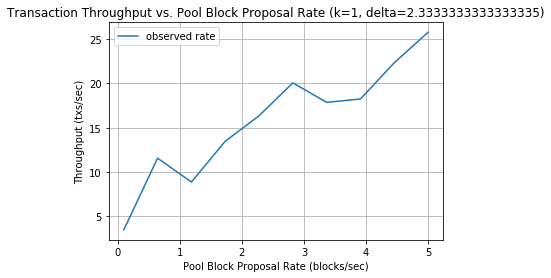

In [6]:
plt.xlabel('Pool Block Proposal Rate (blocks/sec)')
plt.ylabel('Throughput (txs/sec)')
plt.title(f'Transaction Throughput vs. Pool Block Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y1, label='observed rate')
plt.legend()
plt.show()

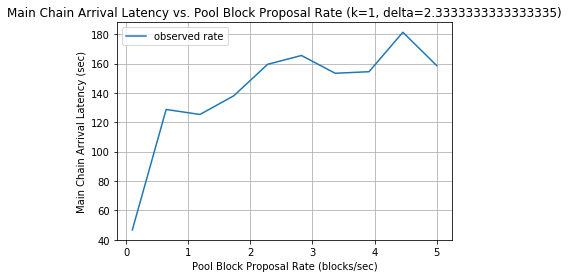

In [7]:
plt.xlabel('Pool Block Proposal Rate (blocks/sec)')
plt.ylabel('Main Chain Arrival Latency (sec)')
plt.title(f'Main Chain Arrival Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y2, label='observed rate')
plt.legend()
plt.show()

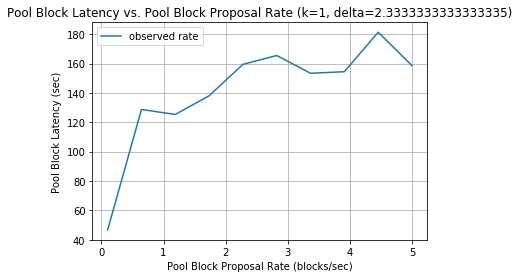

In [8]:
plt.xlabel('Pool Block Proposal Rate (blocks/sec)')
plt.ylabel('Pool Block Latency (sec)')
plt.title(f'Pool Block Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y2, label='observed rate')
plt.legend()
plt.show()

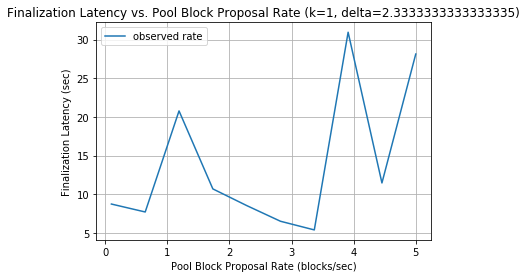

In [9]:
plt.xlabel('Pool Block Proposal Rate (blocks/sec)')
plt.ylabel('Finalization Latency (sec)')
plt.title(f'Finalization Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})')
plt.grid(True)
plt.plot(x, y4, label='observed rate')
plt.legend()
plt.show()

### Results

We can look through the logs of the blocks to understand the process a block undergoes:

In [10]:
with open('../logs/blocks.csv') as f:
    for line in f.readlines()[:10]:
        print(line)

id,parent id,proposal timestamp,pool block timestamp,finalization timestamp,depth,finalized,transactions

Genesis,None,0,None,3.589339873748993,0,True,

9575d,Genesis,9.066282689409247,None,21.52104135514891,1,True,94cf06f0c4;06beb56090;1b4537251d;2d6186e065;747e52182d;3ec7fb0141;99c6a361ed;5cdcad6460;a0c93b5805;1e36ddb320;54812d691d;bb3bc880f1;d710b04c9b;577559afd0;193f2e668c;1b5a73b42d;f7f9230f15;41a3a365d6;cb60e8358b;4486226506;fdafecbfc3;82d261bd55;f9d9426f8f;c27f11a673;393a5f81d0;14a526bce4;e62983293b;18bd679696;2ce73fe6f0;6daf3dccd0;99f9f99bc5;b9c018f211;67d283f0be;2edaf78923;2e26c07328;9fc5270534;c4fbde26a5;bc2f13c38a;b17169d7c1;9f9eb3f3ae;c51c3197d2;6d85dbc8bb;056d2814a5;5948d0a724;9e3eb55241;2b851cf487;ad9f0251db;98b5f9caa1;1184a8df60;f35604716b;dbf9099590

9d1da,None,3.589339873748993,,21.52104135514891,NA,True,94cf06f0c4;06beb56090;1b4537251d;2d6186e065;747e52182d

57dfe,None,7.365162264896657,,21.52104135514891,NA,True,94cf06f0c4;06beb56090;1b4537251d;2d6186e065;747e52182d;

Additionally, we can visualize the results to see the global blocktree. In the following image, blue nodes indicate tree blocks on the main chain and yellow blocks indicate tree blocks
off the main chain (i.e. 'orphan blocks').
![title](../logs/blocktree.png)

We can look through the logs to understand the process a transaction undergoes. A transaction can

1) Be a pool or a tree transaction
2) Be on the main chain or not on the main chain
3) Be finalized or not finalized

Hence, we will analyze each of the following cases:
1) A pool transaction on the main chain that is finalized
2) A pool transaction not on the main chain
3) A tree transaction on the main chain that is finalized
4) A tree transaction on the main chain that is not finalized
5) A tree transaction not on the main chain

In [11]:
import csv

finalized_main_chain_pool_tx = None
not_on_main_chain_pool_tx = None
finalized_main_chain_tree_tx = None
unfinalized_main_chain_tree_tx = None
not_on_main_chain_tree_tx = None

with open('../logs/transactions.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    row_count = 0
    for row in reader:
        if row['finalization timestamp']!='None'and row['main chain arrival timestamp']!='None' and row['pool block timestamp']!='None' and finalized_main_chain_pool_tx==None:
            finalized_main_chain_pool_tx = row
        elif row['main chain arrival timestamp']=='None' and row['pool block timestamp']!='None' and not_on_main_chain_pool_tx==None:
            not_on_main_chain_pool_tx = row
        elif row['finalization timestamp']!='None' and row['main chain arrival timestamp']!='None' and row['pool block timestamp']=='None' and finalized_main_chain_tree_tx==None:
            finalized_main_chain_tree_tx = row
        elif row['finalization timestamp']=='None' and row['main chain arrival timestamp']!='None' and row['pool block timestamp']=='None' and unfinalized_main_chain_tree_tx==None:
            unfinalized_main_chain_tree_tx = row
        elif row['main chain arrival timestamp']=='None' and row['pool block timestamp']=='None' and not_on_main_chain_tree_tx==None: 
            not_on_main_chain_tree_tx = row
        if row_count<10:
            print(row)
        row_count+=1

OrderedDict([('id', '1e36ddb320'), ('source node', '37'), ('generated timestamp', '1.9449882588221448'), ('main chain arrival timestamp', '267.7192870604125'), ('pool block timestamp', '309.20973877274855'), ('finalization timestamp', '266.7480791542135')])
OrderedDict([('id', '54812d691d'), ('source node', '54'), ('generated timestamp', '1.0424026099372323'), ('main chain arrival timestamp', '267.7192870604125'), ('pool block timestamp', '309.20973877274855'), ('finalization timestamp', '266.7480791542135')])
OrderedDict([('id', 'bb3bc880f1'), ('source node', '77'), ('generated timestamp', '1.5227837374509543'), ('main chain arrival timestamp', '267.7192870604125'), ('pool block timestamp', '309.20973877274855'), ('finalization timestamp', '266.7480791542135')])
OrderedDict([('id', 'd710b04c9b'), ('source node', '66'), ('generated timestamp', '0.7421710673388979'), ('main chain arrival timestamp', '267.7192870604125'), ('pool block timestamp', '309.20973877274855'), ('finalization tim

In [12]:
print(f'Finalized Pool Transaction:\n{finalized_main_chain_pool_tx}')
print(f'Pool Transaction Not on Main Chain:\n{not_on_main_chain_pool_tx}')
print(f'Finalized Tree Transaction:\n{finalized_main_chain_tree_tx}')
print(f'Unfinalized Tree Transaction:\n{unfinalized_main_chain_tree_tx}')
print(f'Tree Transaction Not on Main Chain:\n{not_on_main_chain_tree_tx}')


Finalized Pool Transaction:
OrderedDict([('id', '1e36ddb320'), ('source node', '37'), ('generated timestamp', '1.9449882588221448'), ('main chain arrival timestamp', '267.7192870604125'), ('pool block timestamp', '309.20973877274855'), ('finalization timestamp', '266.7480791542135')])
Pool Transaction Not on Main Chain:
OrderedDict([('id', 'f0b337de33'), ('source node', '55'), ('generated timestamp', '3.2035035376885386'), ('main chain arrival timestamp', 'None'), ('pool block timestamp', '262.3368675618195'), ('finalization timestamp', 'None')])
Finalized Tree Transaction:
None
Unfinalized Tree Transaction:
None
Tree Transaction Not on Main Chain:
OrderedDict([('id', 'c76b3741bf'), ('source node', '80'), ('generated timestamp', '17.020348677532382'), ('main chain arrival timestamp', 'None'), ('pool block timestamp', 'None'), ('finalization timestamp', 'None')])


Let's consider the first case of the finalized pool transaction. If we look into `blocks.csv`,
we should be able to see that the transaction's main chain arrival timestamp and pool block timestamp
should be equivalent to a tree block's proposal time. Additionally, the finalization time should be
the tree block's finalization time.

In [13]:
with open('../logs/blocks.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    if finalized_main_chain_pool_tx!=None:
        for row in reader:
            if finalized_main_chain_pool_tx['id'] in row['transactions']:
                print(row)
                break

OrderedDict([('id', '9575d'), ('parent id', 'Genesis'), ('proposal timestamp', '9.066282689409247'), ('pool block timestamp', 'None'), ('finalization timestamp', '21.52104135514891'), ('depth', '1'), ('finalized', 'True'), ('transactions', '94cf06f0c4;06beb56090;1b4537251d;2d6186e065;747e52182d;3ec7fb0141;99c6a361ed;5cdcad6460;a0c93b5805;1e36ddb320;54812d691d;bb3bc880f1;d710b04c9b;577559afd0;193f2e668c;1b5a73b42d;f7f9230f15;41a3a365d6;cb60e8358b;4486226506;fdafecbfc3;82d261bd55;f9d9426f8f;c27f11a673;393a5f81d0;14a526bce4;e62983293b;18bd679696;2ce73fe6f0;6daf3dccd0;99f9f99bc5;b9c018f211;67d283f0be;2edaf78923;2e26c07328;9fc5270534;c4fbde26a5;bc2f13c38a;b17169d7c1;9f9eb3f3ae;c51c3197d2;6d85dbc8bb;056d2814a5;5948d0a724;9e3eb55241;2b851cf487;ad9f0251db;98b5f9caa1;1184a8df60;f35604716b;dbf9099590')])


Now let's consider the second case of the pool transaction not on the main chain.
We should see that it belongs to a block that is not finalized and not on the main chain, indicated
by the fact the block's finalization timestamp and main chain arrival timestamp will both be `'None'`. However, the pool block timestamp should be equal to the block's proposal timestamp.

In [14]:
with open('../logs/blocks.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    if not_on_main_chain_pool_tx!=None:
        for row in reader:
            if not_on_main_chain_pool_tx['id'] in row['transactions']:
                print(row)
                break

OrderedDict([('id', '499f6'), ('parent id', 'None'), ('proposal timestamp', '5.42171711709395'), ('pool block timestamp', ''), ('finalization timestamp', 'None'), ('depth', 'NA'), ('finalized', 'False'), ('transactions', '99f9f99bc5;236e1c748a;c1828a4eca;4125aabcb8;8169c0555a;9af9f1591d;5e5c85e7a5;130914394c;0d6b6dc82c;f0b337de33;0e8b583ecb;7784049675;967ac1b7cb;dc78173696;6833734846')])


The third case is the tree finalized tree transaction on the main chain. We should see that it
belongs to a block with equal finalization and main chain arrival timestamps, but a pool block timestamp equal to `'None'`.

In [15]:
with open('../logs/blocks.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    if finalized_main_chain_tree_tx!=None:
        for row in reader:
            if finalized_main_chain_tree_tx['id'] in row['transactions']:
                print(row)
                break

The fourth case is the unfinalized tree transaction on the main chain. We should see that it
belongs to a block with equal main chain arrival timestamp, but pool block and finalization
timestamps equal to `'None'`.

In [16]:
with open('../logs/blocks.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    if unfinalized_main_chain_tree_tx!=None:
        for row in reader:
            if unfinalized_main_chain_tree_tx['id'] in row['transactions']:
                print(row)
                break

The final case is the tree transaction not on the main chain. The block is not used for any statistics and is not logged.